In [13]:
# Basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Text processing
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import re

# ML models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
pd.set_option('display.max_rows', None)


# Metrics and processing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [7]:
# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

ModuleNotFoundError: No module named 'distutils'

In [2]:
# Load the data
train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')

# Display basic information
print("Training set shape:", train.shape)
print("\nColumns in dataset:", train.columns.tolist())
print("\nSample of the data:")
display(train.head())

# Check class distribution
toxic_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
print("\nClass distribution:")
for column in toxic_columns:
    print(f"{column}: {train[column].value_counts()}")

Training set shape: (159571, 8)

Columns in dataset: ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

Sample of the data:


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0



Class distribution:
toxic: toxic
0    144277
1     15294
Name: count, dtype: int64
severe_toxic: severe_toxic
0    157976
1      1595
Name: count, dtype: int64
obscene: obscene
0    151122
1      8449
Name: count, dtype: int64
threat: threat
0    159093
1       478
Name: count, dtype: int64
insult: insult
0    151694
1      7877
Name: count, dtype: int64
identity_hate: identity_hate
0    158166
1      1405
Name: count, dtype: int64


In [3]:
def clean_text(text):
    """
    Function to clean text data
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Apply cleaning to the comment_text column
train['cleaned_text'] = train['comment_text'].apply(clean_text)
test['cleaned_text'] = test['comment_text'].apply(clean_text)

# Create TF-IDF features
tfidf = TfidfVectorizer(max_features=10000)
X = tfidf.fit_transform(train['cleaned_text'])
X_test = tfidf.transform(test['cleaned_text'])

# Prepare target variables
y = train[toxic_columns].values

[nltk_data] Downloading package punkt to /Users/pranavks/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pranavks/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)

Training set shape: (127656, 10000)
Validation set shape: (31915, 10000)


In [5]:
def train_evaluate_model(model, X_train, X_val, y_train, y_val, model_name):
    """
    Train and evaluate a model
    """
    results = []
    
    # Train and evaluate for each toxic category
    for i, category in enumerate(toxic_columns):
        print(f"\nTraining {model_name} for {category}")
        
        # Train the model
        model.fit(X_train, y_train[:, i])
        
        # Make predictions
        y_pred = model.predict(X_val)
        
        # Calculate metrics
        accuracy = accuracy_score(y_val[:, i], y_pred)
        auc = roc_auc_score(y_val[:, i], y_pred)
        
        results.append({
            'Category': category,
            'Model': model_name,
            'Accuracy': accuracy,
            'AUC': auc
        })
        
        print(f"Accuracy: {accuracy:.4f}")
        print(f"AUC: {auc:.4f}")
        print(classification_report(y_val[:, i], y_pred))
    
    return pd.DataFrame(results)

# Dictionary of traditional ML models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Naive Bayes': MultinomialNB(),
    'Linear SVM': LinearSVC(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier()
}

# Train and evaluate all models
results_df = pd.DataFrame()
for name, model in models.items():
    model_results = train_evaluate_model(model, X_train, X_val, y_train, y_val, name)
    results_df = pd.concat([results_df, model_results])


Training Logistic Regression for toxic
Accuracy: 0.9574
AUC: 0.8060
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     28859
           1       0.91      0.62      0.74      3056

    accuracy                           0.96     31915
   macro avg       0.93      0.81      0.86     31915
weighted avg       0.96      0.96      0.95     31915


Training Logistic Regression for severe_toxic
Accuracy: 0.9906
AUC: 0.6113
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     31594
           1       0.58      0.22      0.32       321

    accuracy                           0.99     31915
   macro avg       0.79      0.61      0.66     31915
weighted avg       0.99      0.99      0.99     31915


Training Logistic Regression for obscene
Accuracy: 0.9763
AUC: 0.8068
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     30200
           1       0.

Using device: cpu
Training Simple Neural Network...

Epoch 1/3
toxic - Accuracy: 0.9551, AUC: 0.7882
severe_toxic - Accuracy: 0.9905, AUC: 0.5404
obscene - Accuracy: 0.9754, AUC: 0.8143
threat - Accuracy: 0.9977, AUC: 0.5000
insult - Accuracy: 0.9682, AUC: 0.7615
identity_hate - Accuracy: 0.9908, AUC: 0.5000

Epoch 2/3
toxic - Accuracy: 0.9585, AUC: 0.8413
severe_toxic - Accuracy: 0.9903, AUC: 0.6790
obscene - Accuracy: 0.9783, AUC: 0.8651
threat - Accuracy: 0.9977, AUC: 0.5000
insult - Accuracy: 0.9698, AUC: 0.8257
identity_hate - Accuracy: 0.9915, AUC: 0.5593

Epoch 3/3
toxic - Accuracy: 0.9590, AUC: 0.8319
severe_toxic - Accuracy: 0.9906, AUC: 0.5820
obscene - Accuracy: 0.9787, AUC: 0.8474
threat - Accuracy: 0.9978, AUC: 0.5203
insult - Accuracy: 0.9704, AUC: 0.7876
identity_hate - Accuracy: 0.9921, AUC: 0.6220

Training CNN Model...

Epoch 1/3
toxic - Accuracy: 0.9525, AUC: 0.7721
severe_toxic - Accuracy: 0.9904, AUC: 0.5819
obscene - Accuracy: 0.9753, AUC: 0.8055
threat - Accuracy

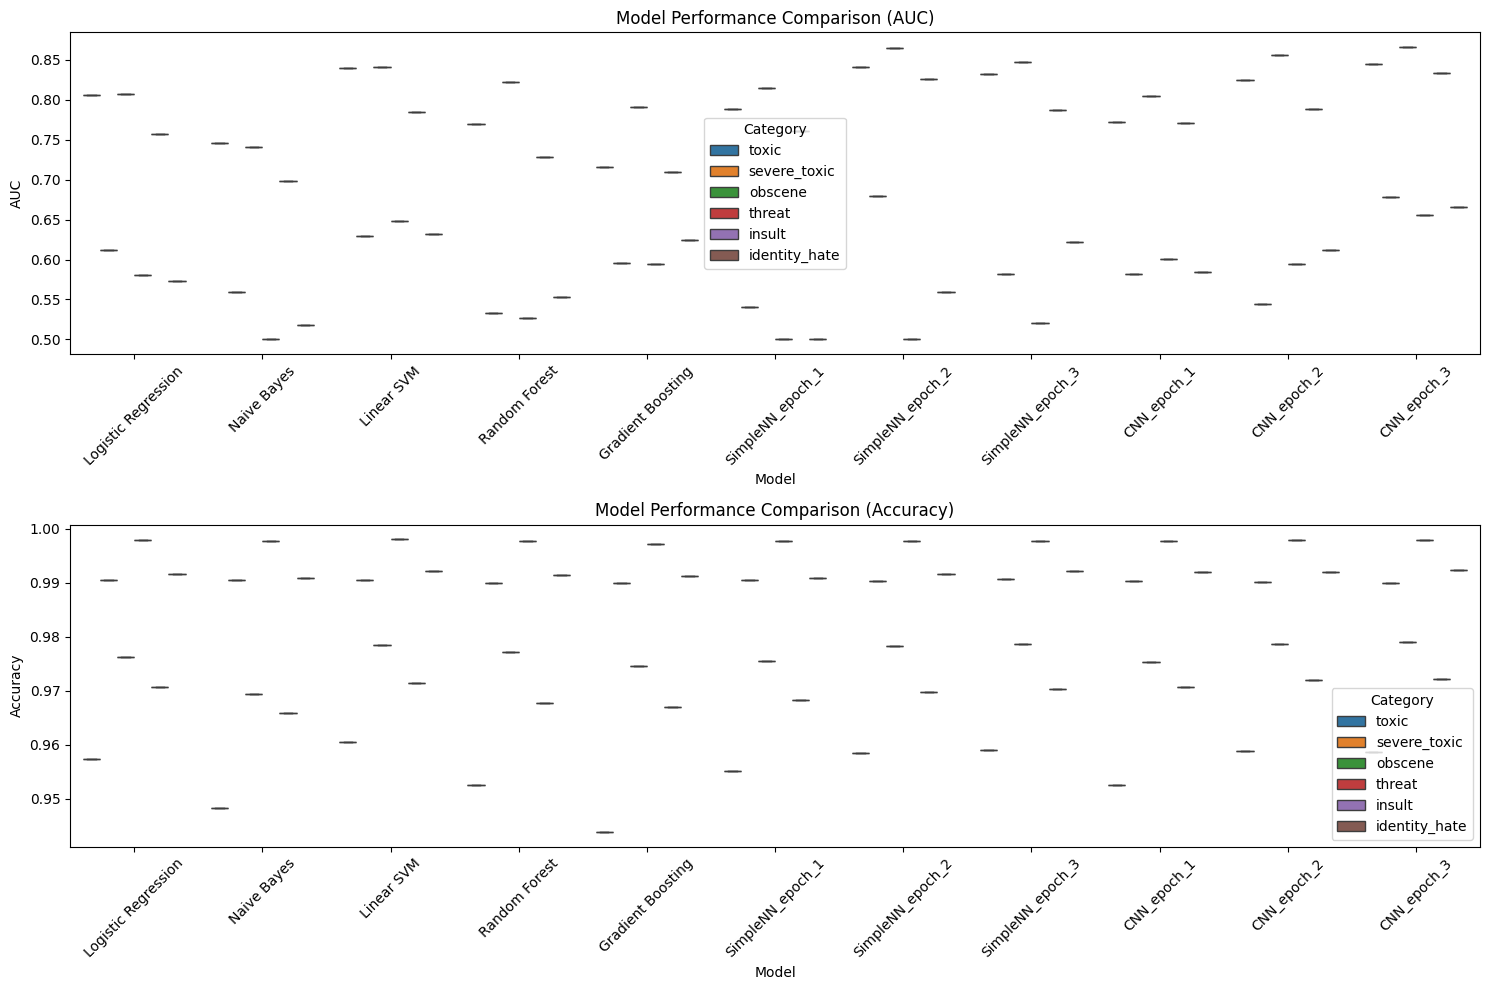


Model Performance Summary:
                                Accuracy       AUC
Model            Category                         
CNN_epoch_1      identity_hate  0.991916  0.584813
                 insult         0.970735  0.771367
                 obscene        0.975309  0.805461
                 severe_toxic   0.990381  0.581937
                 threat         0.997775  0.601163
...                                  ...       ...
SimpleNN_epoch_3 insult         0.970390  0.787610
                 obscene        0.978693  0.847397
                 severe_toxic   0.990600  0.582048
                 threat         0.997775  0.520270
                 toxic          0.959047  0.831946

[66 rows x 2 columns]


In [9]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Custom Dataset class for PyTorch
class TextClassificationDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.FloatTensor(labels)
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return {
            'features': self.features[idx],
            'labels': self.labels[idx]
        }

# Define model architectures
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 6)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.dropout(x)
        x = F.relu(self.layer2(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.layer3(x))
        return x

class CNNTextClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(input_dim * 16, 256)
        self.fc2 = nn.Linear(256, 6)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, n_epochs, model_name):
    results = []
    model = model.to(device)
    
    for epoch in range(n_epochs):
        print(f"\nEpoch {epoch+1}/{n_epochs}")
        
        # Training
        model.train()
        train_loss = 0
        for batch in train_loader:
            features = batch['features'].to(device)
            labels = batch['labels'].to(device)
            
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_predictions = []
        val_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                features = batch['features'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(features)
                predictions = (outputs > 0.5).float()
                
                val_predictions.extend(predictions.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        val_predictions = np.array(val_predictions)
        val_labels = np.array(val_labels)
        
        # Calculate metrics for each category
        for i, category in enumerate(toxic_columns):
            accuracy = accuracy_score(val_labels[:, i], val_predictions[:, i])
            auc = roc_auc_score(val_labels[:, i], val_predictions[:, i])
            
            results.append({
                'Category': category,
                'Model': f"{model_name}_epoch_{epoch+1}",
                'Accuracy': accuracy,
                'AUC': auc
            })
            
            print(f"{category} - Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")
    
    return pd.DataFrame(results)

# Prepare data
X_train_dense = X_train.toarray()
X_val_dense = X_val.toarray()

# Create datasets and dataloaders
train_dataset = TextClassificationDataset(X_train_dense, y_train)
val_dataset = TextClassificationDataset(X_val_dense, y_val)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Initialize models
simple_nn = SimpleNN(input_dim=X_train_dense.shape[1])
cnn_model = CNNTextClassifier(input_dim=X_train_dense.shape[1])

# Training parameters
criterion = nn.BCELoss()
simple_nn_optimizer = torch.optim.Adam(simple_nn.parameters(), lr=0.001)
cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)

# Train models
print("Training Simple Neural Network...")
nn_results = train_model(
    simple_nn, 
    train_loader, 
    val_loader, 
    criterion, 
    simple_nn_optimizer,
    n_epochs=3,
    model_name='SimpleNN'
)

print("\nTraining CNN Model...")
cnn_results = train_model(
    cnn_model, 
    train_loader, 
    val_loader, 
    criterion, 
    cnn_optimizer,
    n_epochs=3,
    model_name='CNN'
)



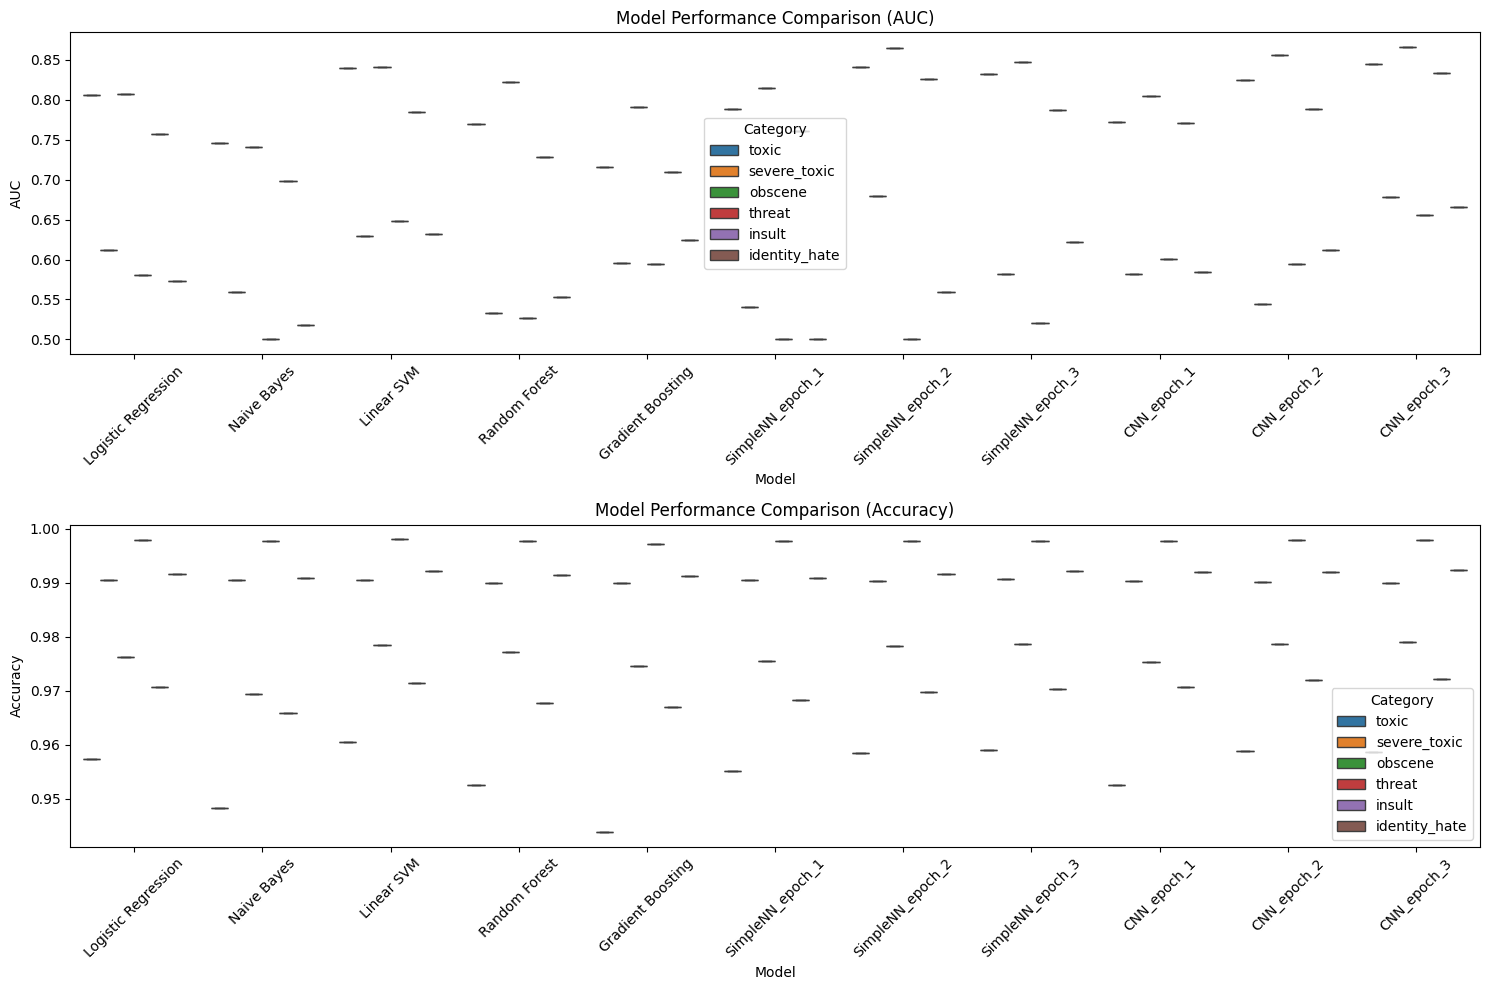


Model Performance Summary:
                                   Accuracy       AUC
Model               Category                         
CNN_epoch_1         identity_hate  0.991916  0.584813
                    insult         0.970735  0.771367
                    obscene        0.975309  0.805461
                    severe_toxic   0.990381  0.581937
                    threat         0.997775  0.601163
                    toxic          0.952467  0.772134
CNN_epoch_2         identity_hate  0.992041  0.611834
                    insult         0.972051  0.789071
                    obscene        0.978725  0.855664
                    severe_toxic   0.990099  0.544792
                    threat         0.997932  0.594500
                    toxic          0.958828  0.824949
CNN_epoch_3         identity_hate  0.992386  0.665923
                    insult         0.972207  0.833147
                    obscene        0.979038  0.866279
                    severe_toxic   0.989911  0.678834


In [14]:
# Combine all results
final_results = pd.concat([results_df, nn_results, cnn_results])

# Visualization
plt.figure(figsize=(15, 10))

# AUC Scores
plt.subplot(2, 1, 1)
sns.boxplot(data=final_results, x='Model', y='AUC', hue='Category')
plt.xticks(rotation=45)
plt.title('Model Performance Comparison (AUC)')

# Accuracy Scores
plt.subplot(2, 1, 2)
sns.boxplot(data=final_results, x='Model', y='Accuracy', hue='Category')
plt.xticks(rotation=45)
plt.title('Model Performance Comparison (Accuracy)')

plt.tight_layout()
plt.show()

# Print summary statistics
summary = final_results.groupby(['Model', 'Category'])[['Accuracy', 'AUC']].mean()
print("\nModel Performance Summary:")
print(summary)